In [2]:
%%bash
pip3 install gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.1
    Uninstalling pygame-2.5.1:
      Successfully uninstalled pygame-2.5.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 8.0 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1") # CartPole-v1 환경 생성

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward')) # 현재 상태, 행동, 다음 상태, 보상


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) # 메모리에서 무작위로 batch_size 만큼 샘플링

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐
    # ([[left0exp,right0exp]...]) 를 반환
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x) # 각 행동의 기대값을 예측

In [6]:
BATCH_SIZE = 128 # 리플레이 버퍼에서 샘플링된 트랜지션의 수
GAMMA = 0.99
EPS_START = 0.9 # 엡실론 초기 값
EPS_END = 0.05 # 엡실론 최종 값
EPS_DECAY = 1000 # 엡실론 지수 감쇠 속도를 제어하는 값, 높을수록 감쇠 속도 느림
TAU = 0.005 # 목표 네트워크의 업데이트 속도
LR = 1e-4 # 옵티마이저의 학습률

# gym 행동 공간에서 행동의 숫자(가능한 행동의 수)를 얻습니다.
n_actions = env.action_space.n

state, info = env.reset() # 초기 상태 얻기
n_observations = len(state) # 관측값의 개수

policy_net = DQN(n_observations, n_actions).to(device) # 정책 네트워크 생성
target_net = DQN(n_observations, n_actions).to(device) # 타겟 네트워크 생성
target_net.load_state_dict(policy_net.state_dict()) # 정책 네트워크의 가중치를 가져옴

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000) # DQN 학습을 위해 과거 경험을 저장하고 샘플링


steps_done = 0 # 학습 단계 수


# 엡실론-그리디 정책을 구현한 함수
def select_action(state):
    global steps_done
    sample = random.random() # 0-1 사이 무작위 값 생성
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1 # 학습 단계 수 증가
    if sample > eps_threshold: # 정책 네트워크에 의한 행동 선택 수행
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있다.
            return policy_net(state).max(1)[1].view(1, 1)
    else: # 무작위 행동 선택
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = [] # 각 에피소드의 지속 시간을 저장하는 리스트


# 에피소드의 지속 시간 시각화하는 함수
def plot_durations(show_result=False):
    plt.figure(1) # 도표 생성
    durations_t = torch.tensor(episode_durations, dtype=torch.float) # 리스트를 텐서로 변환
    if show_result: # 학습 결과
        plt.title('Result')
    else: # 학습 과정 중
        plt.clf() # 도표 지우기
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy()) # 각 에피소드의 지속 시간 그래프
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1) # 100개의 에피소드 평균 지속 시간
        means = torch.cat((torch.zeros(99), means)) # 처음 99개는 0으로 채우고, 그 뒤에 평균 지속 시간 추가
        plt.plot(means.numpy()) # 평균 지속 시간 그래프

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython: # IPython 환경에서 실행 중인지 확인
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE: # 메모리에 저장된 데이터가 BATCH_SIZE 크기보다 작을 경우
        return
    transitions = memory.sample(BATCH_SIZE) # 메모리에서 BATCH_SIZE 크기만큼 트랜지션 데이터 샘플링
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for detailed explanation).
    # batch-array의 Transitions을 Transition의 batch-arrays로 전환
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결
    # (최종 상태는 시뮬레이션이 종료 된 이후의 상태)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool) # 각 상태가 최종 상태인지 아닌지 여부 판단
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]) # 최종 상태가 아닌 다음 상태들을 모아서 하나의 텐서로 합치기
    state_batch = torch.cat(batch.state) # 배치 내의 상태
    action_batch = torch.cat(batch.action) # 배치 내의 행동
    reward_batch = torch.cat(batch.reward) # 배치 내의 보상

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택
    # policy_net에 따라 각 배치 상태에 대해 선택된 행동
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됨
    # max(1)[0]으로 최고의 보상을 선택
    # 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖는다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber Loss 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100) # 그래디언트를 특정 값(100)으로 제한
    optimizer.step()

Complete


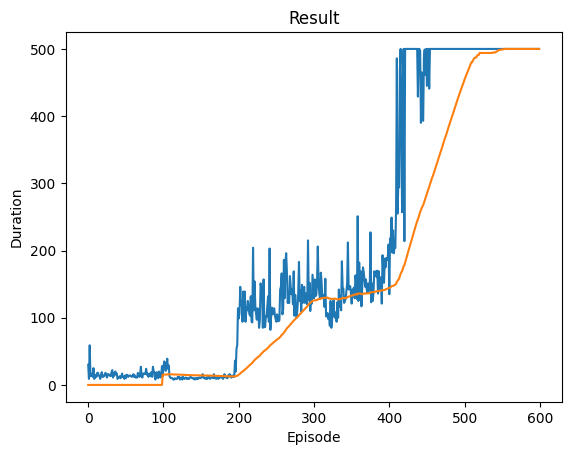

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
if torch.cuda.is_available(): # GPU 사용 가능 여부에 따라 에피소드 수 설정
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes): # 설정한 에피소드 수만큼 반복
    # 환경과 상태 초기화
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) # 초기 상태를 텐서로 변환후 차원을 추가해 입력 가능한 상태로 만들기
    for t in count():
        action = select_action(state) # 현재 상태에 따라 행동 선택
        observation, reward, terminated, truncated, _ = env.step(action.item()) # 액션을 환경에 적용해 다음 관측, 보상, 종료 여부 얻기
        reward = torch.tensor([reward], device=device) # 보상을 텐서로 변환
        done = terminated or truncated # 에피소드가 종료되었거나 환경에서 강제 종료되었는지 여부 확인

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트
        # 목표 네트워크의 가중치가 현재 정책 네트워크의 가중치를 부드럽게 따라가고, 학습의 안정성과 수렴 속도를 향상시킴
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1) # 에피소드 지속 시간 리스트에 추가
            plot_durations() # 현재까지 학습 결과 시각화
            break

print('Complete') # 모든 에피소드 완료
plot_durations(show_result=True) # 학습 결과 최종 시각화
plt.ioff() # 인터랙티브 모드 끄기
plt.show() # 최종 결과 그래프 표시